In [1]:
import numpy as np
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import os
import gc
from pathlib import Path



2023-12-04 17:15:17.929045: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 17:15:17.961862: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 17:15:18.420039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-12-04 17:15:18.892186: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 17:15:18.904235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 17:15:18.904363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
MODEL_SAVE_DIR = Path("DNN_model_medium")
if not MODEL_SAVE_DIR.exists():
    os.makedirs(MODEL_SAVE_DIR.as_posix())

### Loading data files

In [7]:
def get_data_files(path="../../torcs_SL/data_all/data", pick_train=None, pick_test=None):
    train_files = []
    val_files = []

    path = Path(path)
    tracks = os.listdir(path.as_posix())

    train_tracks = ['g-track-1', 'g-track-2', 'g-track-3', 'g-track-4', 'spring', 'aalborg', 'wheel-1', 'wheel-2', 'e-track-1', 'e-track-2']
    test_tracks = ['e-track-3', 'alpine-2', 'corkscrew', 'wheel-2','ruudskogen']

    random_tracks = np.random.choice(tracks, len(tracks), replace=False)
    random_tracks = [x for x in random_tracks if x[:4] != 'dirt' and x[:3] != 'mix' and x not in test_tracks and x not in train_tracks]

    val_tracks = test_tracks # random_tracks#[:3]
    train_tracks.extend(random_tracks[:8])

    track_files = list(path.glob("**/*.csv"))


    train_track_files = [x for x in track_files if x.parts[-2] in train_tracks]
    val_track_files = [x for x in track_files if x.parts[-2] in val_tracks]
    
    
    train_track_files = np.random.choice(train_track_files, pick_train, replace=False) if pick_train else train_track_files
    val_track_files = np.random.choice(val_track_files, pick_test, replace=False) if pick_test else val_track_files

    return train_track_files, val_track_files

In [8]:
empty_train_track_files, empty_val_track_files = get_data_files(path="../../torcs_SL/data_all/data")
empty_train_track_files, empty_val_track_files

([PosixPath('../../torcs_SL/data_all/data/g-track-2/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-2/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-2/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/forza/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/forza/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/forza/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/aalborg/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/aalborg/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/aalborg/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/wheel-1/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/wheel-1/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/wheel-1/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/alpine-1/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/alpine-1/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/alpine-1/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/e-track-4/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/e-track-4

In [10]:
traffic_train_track_files, traffic_val_track_files = get_data_files("../../torcs_SL/TORCS_DATA/data", 25, 12)
traffic_train_track_files, traffic_val_track_files

(array([PosixPath('../../torcs_SL/TORCS_DATA/data/g-track-2/24.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/e-track-5/2.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/d-speedway/11.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/ole-road-1/25.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/wheel-1/23.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/e-track-4/6.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/d-speedway/26.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/g-speedway/12.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/g-speedway/7.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/g-track-3/2.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/c-speedway/15.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/spring/13.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/aalborg/23.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/spring/9.csv'),
        PosixPath('../../torc

### Train-Test Split

In [11]:
empty_training_data = pd.DataFrame()
empty_validation_data = pd.DataFrame()
split_ratio = 0.8

for fi in empty_train_track_files:
    empty_training_data = pd.concat([empty_training_data, pd.read_csv(fi)]).reset_index(drop=True)

for fi in empty_val_track_files:

    empty_validation_data = pd.concat([empty_validation_data, pd.read_csv(fi)]).reset_index(drop=True)

print (empty_training_data.shape)
print (empty_validation_data.shape)

(365361, 79)
(121802, 79)


In [12]:
traffic_training_data = pd.DataFrame()
traffic_validation_data = pd.DataFrame()
split_ratio = 0.8

for fi in traffic_train_track_files:
    traffic_training_data = pd.concat([traffic_training_data, pd.read_csv(fi)]).reset_index(drop=True)

for fi in traffic_val_track_files:

    traffic_validation_data = pd.concat([traffic_validation_data, pd.read_csv(fi)]).reset_index(drop=True)
    
print (traffic_training_data.shape)
print (traffic_validation_data.shape)

(433555, 79)
(186832, 79)


In [13]:
training_data = pd.concat([empty_training_data, traffic_training_data]).reset_index(drop=True)
validation_data = pd.concat([empty_validation_data, traffic_validation_data]).reset_index(drop=True)


### Train-Test Split

In [14]:
training_data.columns.values

array(['Angle', ' CurrentLapTime', ' Damage', ' DistanceFromStart',
       ' DistanceCovered', ' FuelLevel', ' Gear', ' LastLapTime',
       ' Opponent_1', 'Opponent_2', 'Opponent_3', 'Opponent_4',
       'Opponent_5', 'Opponent_6', 'Opponent_7', 'Opponent_8',
       'Opponent_9', 'Opponent_10', 'Opponent_11', 'Opponent_12',
       'Opponent_13', 'Opponent_14', 'Opponent_15', 'Opponent_16',
       'Opponent_17', 'Opponent_18', 'Opponent_19', 'Opponent_20',
       'Opponent_21', 'Opponent_22', 'Opponent_23', 'Opponent_24',
       'Opponent_25', 'Opponent_26', 'Opponent_27', 'Opponent_28',
       'Opponent_29', 'Opponent_30', 'Opponent_31', 'Opponent_32',
       'Opponent_33', 'Opponent_34', 'Opponent_35', 'Opponent_36',
       'RacePosition', ' RPM', ' SpeedX', ' SpeedY', ' SpeedZ',
       ' Track_1', 'Track_2', 'Track_3', 'Track_4', 'Track_5', 'Track_6',
       'Track_7', 'Track_8', 'Track_9', 'Track_10', 'Track_11',
       'Track_12', 'Track_13', 'Track_14', 'Track_15', 'Track_16',
  

In [15]:
del training_data[' CurrentLapTime']
del validation_data[' CurrentLapTime']
del training_data[' LastLapTime']
del validation_data[' LastLapTime']
del training_data[' Damage']
del validation_data[' Damage']
del training_data[' FuelLevel']
del validation_data[' FuelLevel']

del training_data[' DistanceFromStart']
del validation_data[' DistanceFromStart']


del training_data['RacePosition']
del validation_data['RacePosition']

# for col in [c for c in training_data.columns if c.strip()[:3] == "Opp"]:
#     del training_data[col]
#     del validation_data[col]
            

In [16]:
training_data.columns

Index(['Angle', ' DistanceCovered', ' Gear', ' Opponent_1', 'Opponent_2',
       'Opponent_3', 'Opponent_4', 'Opponent_5', 'Opponent_6', 'Opponent_7',
       'Opponent_8', 'Opponent_9', 'Opponent_10', 'Opponent_11', 'Opponent_12',
       'Opponent_13', 'Opponent_14', 'Opponent_15', 'Opponent_16',
       'Opponent_17', 'Opponent_18', 'Opponent_19', 'Opponent_20',
       'Opponent_21', 'Opponent_22', 'Opponent_23', 'Opponent_24',
       'Opponent_25', 'Opponent_26', 'Opponent_27', 'Opponent_28',
       'Opponent_29', 'Opponent_30', 'Opponent_31', 'Opponent_32',
       'Opponent_33', 'Opponent_34', 'Opponent_35', 'Opponent_36', ' RPM',
       ' SpeedX', ' SpeedY', ' SpeedZ', ' Track_1', 'Track_2', 'Track_3',
       'Track_4', 'Track_5', 'Track_6', 'Track_7', 'Track_8', 'Track_9',
       'Track_10', 'Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15',
       'Track_16', 'Track_17', 'Track_18', 'Track_19', 'TrackPosition',
       ' WheelSpinVelocity_1', 'WheelSpinVelocity_2', 'WheelS

In [17]:
X_train=training_data.loc[:,'Angle':'Z']
Y_train=training_data.loc[:,'Steering']
X_val=validation_data.loc[:,'Angle':'Z']
Y_val=validation_data.loc[:,'Steering']

In [18]:
training_data.columns

Index(['Angle', ' DistanceCovered', ' Gear', ' Opponent_1', 'Opponent_2',
       'Opponent_3', 'Opponent_4', 'Opponent_5', 'Opponent_6', 'Opponent_7',
       'Opponent_8', 'Opponent_9', 'Opponent_10', 'Opponent_11', 'Opponent_12',
       'Opponent_13', 'Opponent_14', 'Opponent_15', 'Opponent_16',
       'Opponent_17', 'Opponent_18', 'Opponent_19', 'Opponent_20',
       'Opponent_21', 'Opponent_22', 'Opponent_23', 'Opponent_24',
       'Opponent_25', 'Opponent_26', 'Opponent_27', 'Opponent_28',
       'Opponent_29', 'Opponent_30', 'Opponent_31', 'Opponent_32',
       'Opponent_33', 'Opponent_34', 'Opponent_35', 'Opponent_36', ' RPM',
       ' SpeedX', ' SpeedY', ' SpeedZ', ' Track_1', 'Track_2', 'Track_3',
       'Track_4', 'Track_5', 'Track_6', 'Track_7', 'Track_8', 'Track_9',
       'Track_10', 'Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15',
       'Track_16', 'Track_17', 'Track_18', 'Track_19', 'TrackPosition',
       ' WheelSpinVelocity_1', 'WheelSpinVelocity_2', 'WheelS

In [19]:
print (X_train.shape)
print (Y_train.shape)
print (X_val.shape)
print (Y_val.shape)
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_val=scaler.fit_transform(X_val)
Y_train=Y_train.values.reshape((-1, 1))
Y_val=Y_val.values.reshape((-1, 1))
print (X_train.shape)
print (Y_train.shape)
print (X_val.shape)
print (Y_val.shape)

(798916, 68)
(798916,)
(308634, 68)
(308634,)
(798916, 68)
(798916, 1)
(308634, 68)
(308634, 1)


### Save these means and stds for test time

In [20]:
with open(MODEL_SAVE_DIR.joinpath("scaler.pickle").as_posix(), "wb") as fp:
    pickle.dump(scaler, fp)

In [21]:
scaler.mean_

array([-1.35257724e-02,  5.70494519e+03,  3.24922724e+00,  1.80168835e+02,
        1.90658458e+02,  1.93294592e+02,  1.95329479e+02,  1.96313825e+02,
        1.97595207e+02,  1.98190752e+02,  1.98582402e+02,  1.98515319e+02,
        1.98501251e+02,  1.98181006e+02,  1.97819793e+02,  1.97165843e+02,
        1.96290253e+02,  1.94351629e+02,  1.92707014e+02,  1.89803677e+02,
        1.80133211e+02,  1.79817268e+02,  1.90898324e+02,  1.94094187e+02,
        1.96590090e+02,  1.97917984e+02,  1.98601619e+02,  1.99002757e+02,
        1.99117074e+02,  1.99241947e+02,  1.99041144e+02,  1.98961701e+02,
        1.98719237e+02,  1.98384649e+02,  1.97478440e+02,  1.96002725e+02,
        1.93229179e+02,  1.88373730e+02,  1.81658729e+02,  7.88059543e+03,
        1.57329062e+02, -7.38250189e-01,  4.00344534e-02,  5.83983311e+00,
        6.03657482e+00,  7.61161437e+00,  1.02851367e+01,  2.01358267e+01,
        2.70389777e+01,  3.80623357e+01,  6.39158612e+01,  8.40120363e+01,
        8.38421394e+01,  

In [22]:
scaler.scale_

array([2.30996945e-01, 3.97583394e+03, 9.91718792e-01, 5.04585190e+01,
       3.62873696e+01, 2.97341602e+01, 2.38279878e+01, 2.08409884e+01,
       1.64434518e+01, 1.51226642e+01, 1.32501745e+01, 1.41223856e+01,
       1.35709805e+01, 1.50142407e+01, 1.62214208e+01, 1.79533617e+01,
       2.09346305e+01, 2.58125381e+01, 3.07113627e+01, 3.76009959e+01,
       5.12143364e+01, 5.14468061e+01, 3.60055368e+01, 2.84259175e+01,
       2.01349365e+01, 1.52523347e+01, 1.25082467e+01, 1.05656341e+01,
       9.99173377e+00, 9.22491845e+00, 1.08564576e+01, 1.14288723e+01,
       1.25091660e+01, 1.40217957e+01, 1.70219527e+01, 2.20774356e+01,
       2.94188499e+01, 3.96678849e+01, 4.98653935e+01, 1.15629733e+03,
       5.00974215e+01, 5.36117435e+00, 7.18695401e+00, 3.41078913e+00,
       3.43097815e+00, 4.53860228e+00, 6.39283309e+00, 1.96647148e+01,
       2.20039298e+01, 2.36907323e+01, 3.85836928e+01, 5.84813873e+01,
       5.73832851e+01, 5.59052849e+01, 3.75427118e+01, 3.08036979e+01,
      

In [23]:
np.save(MODEL_SAVE_DIR.joinpath("means.npy"), scaler.mean_)
np.save(MODEL_SAVE_DIR.joinpath("stds.npy"), scaler.scale_)

## Model Building

In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5,epsilon=0.0001, min_lr=0)

In [25]:
learning_rate=1e-1
output_dim=Y_train.shape[1]
model=Sequential()
model.add(Dense(512
                ,input_shape=(X_train.shape[1],),activation='relu',kernel_initializer='he_normal'))
# model.add(Dense(512,activation='relu',kernel_initializer='he_normal'))
model.add(Dense(256,activation='relu',kernel_initializer='he_normal'))
model.add(Dense(128,activation='relu',kernel_initializer='he_normal'))
model.add(Dense(64,activation='relu',kernel_initializer='he_normal'))
model.add(Dense(32,activation='relu',kernel_initializer='he_normal'))
model.add(Dense(8,activation='relu',kernel_initializer='he_normal'))
model.add(Dense(4,activation='relu',kernel_initializer='he_normal'))
model.add(Dense(1,kernel_initializer='he_normal'))
model.compile(optimizer=Adam(learning_rate),loss='mean_absolute_error',metrics=['mae'])


2023-12-04 17:16:08.806169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 17:16:08.806384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 17:16:08.806500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               35328     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
 dense_6 (Dense)             (None, 4)                 3

In [27]:
stats = model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=256,epochs=50, callbacks=[reduce_lr])

Epoch 1/50


2023-12-04 17:16:11.760268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-04 17:16:11.768410: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x38dc2a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-04 17:16:11.768426: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-12-04 17:16:11.771900: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-04 17:16:11.782841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-12-04 17:16:11.883675: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

3121/3121 [==============================] - 9s 2ms/step - loss: 2.9958 - mae: 2.9958 - val_loss: 0.1043 - val_mae: 0.1043 - lr: 0.1000
Epoch 2/50
3121/3121 [==============================] - 6s 2ms/step - loss: 0.1015 - mae: 0.1015 - val_loss: 0.1044 - val_mae: 0.1044 - lr: 0.1000
Epoch 3/50
3121/3121 [==============================] - 7s 2ms/step - loss: 0.1015 - mae: 0.1015 - val_loss: 0.1046 - val_mae: 0.1046 - lr: 0.1000
Epoch 4/50
3121/3121 [==============================] - 7s 2ms/step - loss: 0.1015 - mae: 0.1015 - val_loss: 0.1053 - val_mae: 0.1053 - lr: 0.1000
Epoch 5/50
3121/3121 [==============================] - 7s 2ms/step - loss: 0.1015 - mae: 0.1015 - val_loss: 0.1088 - val_mae: 0.1088 - lr: 0.1000
Epoch 6/50
3121/3121 [==============================] - 6s 2ms/step - loss: 0.1015 - mae: 0.1015 - val_loss: 0.1051 - val_mae: 0.1051 - lr: 0.1000
Epoch 7/50
3121/3121 [==============================] - 7s 2ms/step - loss: 0.1008 - mae: 0.1008 - val_loss: 0.1044 - val_mae: 0.


KeyboardInterrupt



In [28]:
model.save(MODEL_SAVE_DIR.joinpath('model.h5'))

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


NameError: name 'stats' is not defined

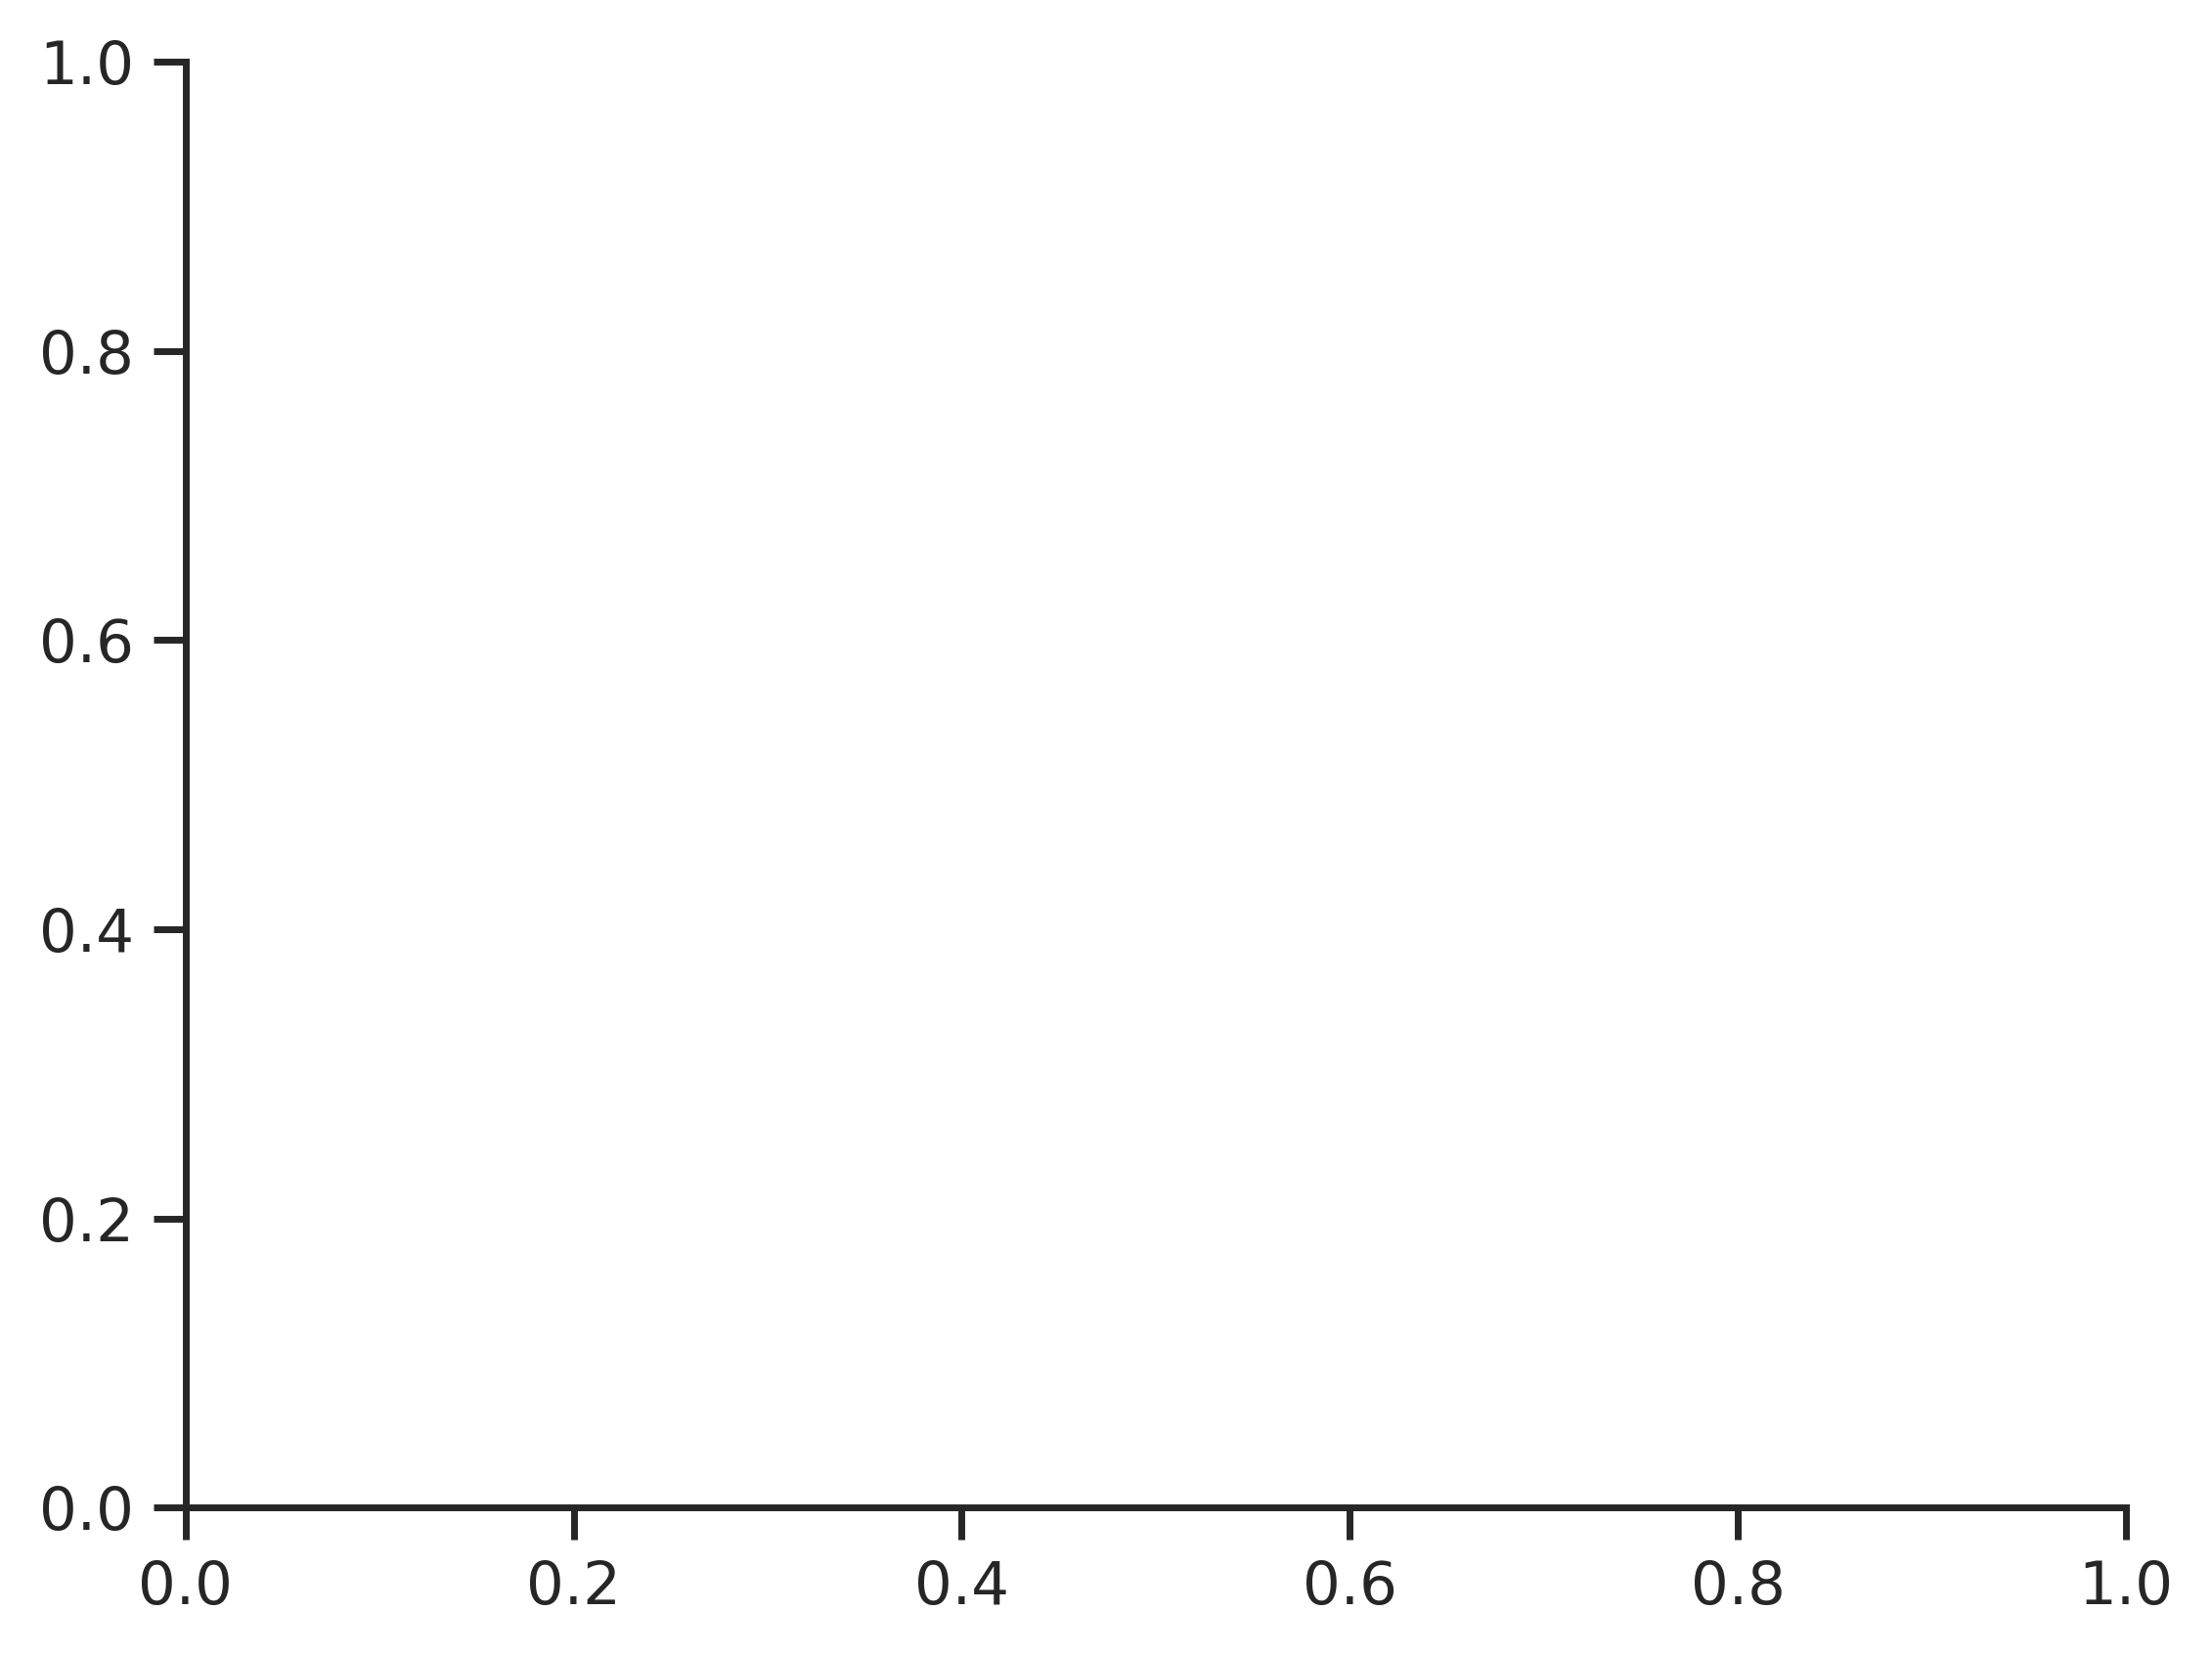

In [30]:
fig, ax = plt.subplots(dpi=400)
ax.plot(stats.history['loss'])
ax.plot(stats.history['val_loss'])
ax.legend(['Training Loss', 'Validation Loss'])
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Absolute Error")

fig.savefig(MODEL_SAVE_DIR.joinpath("dnn_loss.png"))